# Analysis of NEISS Micromobility ER Records

# Project Premise 

## Introduction
Micromobility devices are defined as small, wheeled transportation devices intended for short distance travel and are often powered by electricity or human force. In recent years, there has been an increase in the usage of micromobility devices within urbanized environment as a more sustainable and cheaper alternative mode of transportation compared to motor vehicles. This uptick in micromobility device usage has resulted in an increase of emergency room visits for injuries associated with them. Despite their growing popularity, there is an insufficient understanding of the impact of micromobility device usage on the public health. 

## Project Problem

1) Is there a "best performing" model that can accurately predict future patient's hospitalization outcomes between the following classification methods: **logistic regression**, **LDA**, **Classification Tree**, **SVM**, and **Deep Learning**? 
2) Can we identify the risk factors associated with patient's hospitalization rate using the "best" performing model?

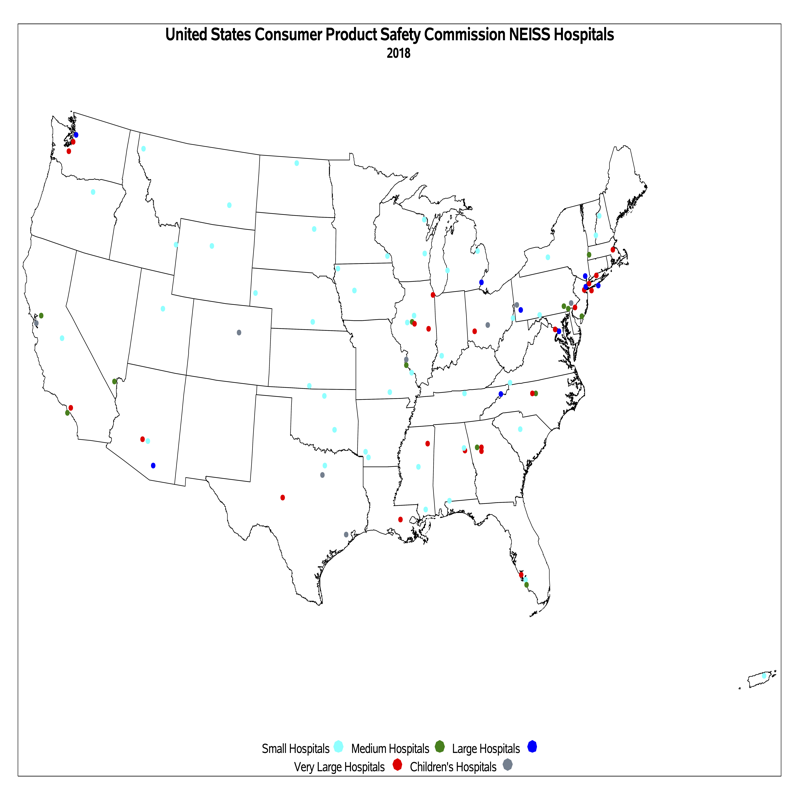

In [1]:
from PIL import Image
img = Image.open('/Users/trucle/Desktop/math251/project/data/NEISS_Hospital_Map_2018.png').resize((800, 800))
img

# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Read the files
df_3215 = pd.read_excel('/Users/trucle/Desktop/math251/project/data/3215_all_years_coded.XLSX', skiprows=[0, 1])  
df_5040 = pd.read_excel('/Users/trucle/Desktop/math251/project/data/5040_all_years_coded.xlsx', skiprows=[0, 1])  

In [4]:
df_comb = pd.concat([df_3215, df_5040], ignore_index=True, axis=0) # combine the two datasets together
df_comb

CPSC_Case_Number       Treatment_Date  Age  Sex  Race Other_Race  \
0            200112799  2020-01-04 00:00:00   23    1     0        NaN   
1            200112834  2020-01-04 00:00:00   31    1     0        NaN   
2            200112982  2020-01-02 00:00:00   21    2     0        NaN   
3            200113059  2020-01-04 00:00:00   34    1     0        NaN   
4            200115359  2020-01-05 00:00:00   64    1     0        NaN   
...                ...                  ...  ...  ...   ...        ...   
6344         220747220  2022-06-13 00:00:00   55    2     4        NaN   
6345         221250776  2022-11-21 00:00:00   54    1     1        NaN   
6346         220413033  2022-03-19 00:00:00   47    1     2        NaN   
6347         220865366  2022-08-12 00:00:00    8    1     1        NaN   
6348         230117217  2022-10-15 00:00:00   48    2     1        NaN   

      Hispanic  Body_Part  Diagnosis Other_Diagnosis  ...  \
0            0         79         71            PAIN  ...   
1            0         82         59             NaN  ...   
2            2         79         57             NaN  ...   
3            2         75         62             NaN  ...   
4            2         76         57             NaN  ...   
...        ...        ...        ...             ...  ...   
6344         0         37         53             NaN  ...   
6345         2         31         71            PAIN  ...   
6346         2         75         62             NaN  ...   
6347         2         75         62             NaN  ...   
6348         2         76         57             NaN  ...   

      C:Swerving/braking on account of some other activity in the roadway.   \
0                                                     0                       
1                                                     0                       
2                                                     0                       
3                                                     0                       
4                                                     0                       
...                                                 ...                       
6344                                                  0                       
6345                                                  0                       
6346                                                  0                       
6347                                                  0                       
6348                                                  0                       

      D:Slope E:Travel surface  F: More than one person on the device  \
0         NaN              NaN                                      0   
1         NaN              NaN                                      0   
2         NaN              NaN                                      0   
3         NaN              NaN                                      0   
4         NaN              NaN                                      0   
...       ...              ...                                    ...   
6344      NaN              NaN                                      0   
6345      NaN              NaN                                      0   
6346      NaN              NaN                                      0   
6347      NaN              NaN                                      0   
6348      NaN              NaN                                      0   

      G: Mechanical failure of the device  H:Other  I: No explanation given  \
0                                       0        0                        0   
1                                       0        0                        0   
2                                       0        0                        0   
3                                       0        0                        0   
4                                       0        0                        0   
...                                   ...      ...                      ...   
6344 

In [5]:
print(df_comb.columns)
print(len(df_comb.columns))

Index(['CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex', 'Race',
       'Other_Race', 'Hispanic', 'Body_Part', 'Diagnosis', 'Other_Diagnosis',
       'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2', 'Disposition',
       'Location', 'Fire_Involvement', 'Alcohol', 'Drug', 'Product_1',
       'Product_2', 'Product_3', 'Narrative_1',
       'Coding for what happened to "bystanders"', 'Stratum', 'PSU', 'Weight',
       'Device type', 'Notes', 'Operator traveling on device',
       'Passenger traveling on device:', 'Non-travel by device owner/user:',
       'Bystander (not using device)', 'None of the above OR cannot tell',
       'Patient falls off device ', 'Patient hit by vehicle',
       'Patient hits vehicle', 'Patient collides with vehicle: ',
       'Patient hit by device: ', 'Patient hits device:',
       'Patient collides with other device:',
       'C:Patient hits stationary object: ', 'D:Other/Unknown',
       'A:Swerving/braking to avoid a vehicle (but no collision).',
     

In [6]:
# Combine the dummy variables into the appropiate predictors based on level
# return three new predictors: patient_activity, accident_cause, precipitated_cause
def combo_activity(df):
    df['Passenger traveling on device:'] = df['Passenger traveling on device:'].replace(1, 2)
    df['Non-travel by device owner/user:'] = df['Non-travel by device owner/user:'].replace(1, 3)
    df['Bystander (not using device)'] = df['Bystander (not using device)'].replace(1, 4)
    df['None of the above OR cannot tell'] = df['None of the above OR cannot tell'].replace(1, 5)

    df['patient_activity'] = df['Operator traveling on device'] + df['Passenger traveling on device:'] + df['Non-travel by device owner/user:'] + df['Bystander (not using device)'] + df['None of the above OR cannot tell']

    df['Patient hit by vehicle'] = df['Patient hit by vehicle'].replace(1, 2)
    df['Patient hits vehicle'] = df['Patient hits vehicle'].replace(1,3)
    df['Patient collides with vehicle: '] = df['Patient collides with vehicle: '].replace(1,4)
    df['Patient hit by device: '] = df['Patient hit by device: '].replace(1,5)
    df['Patient hits device:'] = df['Patient hits device:'].replace(1,6)
    df['Patient collides with other device:'] = df['Patient collides with other device:'].replace(1,7)
    df['C:Patient hits stationary object: '] = df['C:Patient hits stationary object: '].replace(1,8)
    df['D:Other/Unknown'] = df['D:Other/Unknown'].replace(1,9)

    df['accident_cause'] = df['Patient falls off device '] + df['Patient hit by vehicle'] + df['Patient hits vehicle'] + df['Patient collides with vehicle: '] + df['Patient hit by device: '] + df['Patient hits device:'] + df['Patient collides with other device:'] + df['C:Patient hits stationary object: '] + df['D:Other/Unknown']

    df['B:Swerving/braking to avoid a roadway user(s) OTHER than a vehicle '] = df['B:Swerving/braking to avoid a roadway user(s) OTHER than a vehicle '].replace(1,2)
    df['C:Swerving/braking on account of some other activity in the roadway. '] = df['C:Swerving/braking on account of some other activity in the roadway. '].replace(1,3)

    df['precipitated_cause'] = df['A:Swerving/braking to avoid a vehicle (but no collision).'] +  df['B:Swerving/braking to avoid a roadway user(s) OTHER than a vehicle '] + df['C:Swerving/braking on account of some other activity in the roadway. ']

    return df



In [7]:
new_df = combo_activity(df_comb)

In [8]:
# any age that is greater than 120 means that they're inputting the age of a child in months
# divide any entries that have age greater than 120 by 12 to get the year
new_df.loc[new_df['Age']>120,'Age'] = new_df['Age']/12

/var/folders/8x/9c13ztpj5d34cm9xd3y0hjyc0000gn/T/ipykernel_2177/1227653899.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[17.66666667 18.16666667 18.08333333 18.58333333 18.5        18.58333333
 18.         17.58333333 17.66666667 18.5        18.25      ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df['Age']>120,'Age'] = new_df['Age']/12


In [9]:
# Make new predictor to indicate whether patient is hospitalized or not based on their disposition status
new_df['hospitalization'] = new_df['Disposition'].replace([2, 4, 5, 8, 1, 6], ['yes', 'yes', 'yes', 'yes', 'no', 'no'])

**[1]**: Treated and released, or examined and released without treatment (also includestransfers for treatment to another department of the same facility without admission) -> **No** \
**[2]**: Treated and transferred to another hospital -> **Yes** \
**[4]**: Treated and admitted for hospitalization (within same facility) -> **Yes** \
**[5]**: Held for observation (includes admitted for observation) -> **Yes**\
**[6]**: Left without being seen, Left against medical advice, Left without treatment, Eloped -> **No**\
**[8]**: Fatality, includes dead on arrival (“DOA”), died in the ED, and died after admission -> **Yes**

In [10]:
# Change numbering to the appropiate label
new_df['Sex'] = new_df['Sex'].replace([0, 1, 2, 3], ['Not Recorded', 'Male', 'Female', 'Other'])

**[0]**: Not recorded/Unknown\
**[1]**: Male \
**[2]**: Gender diverse & intersex encompasses but is not limited to all of the following identities: transgender, male to female; transgender, female to male; transgender, gender nonconforming; gender fluid; genderqueer; polygender/pangender; omnigender; non-binary; bigender; agender; Two-spirit identities; Fa’afafine; Hijras; Khanith; intersex. \
**[3]**: Not recorded/Unknown

In [11]:
# drop dummy variables and the Sex and Disposition predictors

new_df.drop(['Other_Race', 'Other_Diagnosis', 'Other_Diagnosis_2', 'Product_1',
       'Product_2', 'Product_3', 'Coding for what happened to "bystanders"', 'Narrative_1', 'Stratum', 'PSU', 'Notes','D:Slope', 'E:Travel surface', 'H:Other',
       'I: No explanation given', 'Helmet', 'Location.1', 'Sex.1', 'Operator traveling on device',
       'Passenger traveling on device:', 'Non-travel by device owner/user:',
       'Bystander (not using device)', 'None of the above OR cannot tell',
       'Patient falls off device ', 'Patient hit by vehicle',
       'Patient hits vehicle', 'Patient collides with vehicle: ',
       'Patient hit by device: ', 'Patient hits device:',
       'Patient collides with other device:',
       'C:Patient hits stationary object: ', 'D:Other/Unknown',
       'A:Swerving/braking to avoid a vehicle (but no collision).',
       'B:Swerving/braking to avoid a roadway user(s) OTHER than a vehicle ',
       'C:Swerving/braking on account of some other activity in the roadway. ',
       'Disposition'], axis=1, inplace=True)

In [12]:
# Filter the dataframe for mopeds, electric bike, and human powered bike cases
df = new_df[new_df['Device type'].isin(['MP', 'BE', 'BU'])]
df

CPSC_Case_Number       Treatment_Date   Age     Sex  Race  Hispanic  \
0            200112799  2020-01-04 00:00:00  23.0    Male     0         0   
1            200112834  2020-01-04 00:00:00  31.0    Male     0         0   
3            200113059  2020-01-04 00:00:00  34.0    Male     0         2   
4            200115359  2020-01-05 00:00:00  64.0    Male     0         2   
5            200115381  2020-01-05 00:00:00  49.0    Male     1         2   
...                ...                  ...   ...     ...   ...       ...   
6344         220747220  2022-06-13 00:00:00  55.0  Female     4         0   
6345         221250776  2022-11-21 00:00:00  54.0    Male     1         2   
6346         220413033  2022-03-19 00:00:00  47.0    Male     2         2   
6347         220865366  2022-08-12 00:00:00   8.0    Male     1         2   
6348         230117217  2022-10-15 00:00:00  48.0  Female     1         2   

      Body_Part  Diagnosis  Body_Part_2  Diagnosis_2  ...  Alcohol  Drug  \
0            79         71         35.0         71.0  ...        0     0   
1            82         59         32.0         59.0  ...        0     0   
3            75         62         75.0         58.0  ...        1     0   
4            76         57         75.0         52.0  ...        0     0   
5            33         59         32.0         53.0  ...        0     0   
...         ...        ...          ...          ...  ...      ...   ...   
6344         37         53          NaN          NaN  ...        0     0   
6345         31         71         85.0         68.0  ...        0     1   
6346         75         62          NaN          NaN  ...        0     0   
6347         75         62         76.0         53.0  ...        0     0   
6348         76         57         76.0         58.0  ...        0     0   

       Weight  Device type  F: More than one person on the device  \
0     78.1602           MP                                      0   
1     15.9992           MP                                      0   
3     15.9992           MP                                      0   
4     15.9992           BE                                      0   
5     78.1602           MP                                      1   
...       ...          ...                                    ...   
6344  18.1791           BU                                      0   
6345  64.7151           BU                                      0   
6346  57.5246           BU                                      0   
6347  64.7151           BU                                      0   
6348  17.2223           BU                                      0   

     G: Mechanical failure of the device  patient_activity  accident_cause  \
0                                      0                 1               9   
1                                      0                 1               4   
3                                      0                 1               3   
4                                      0                 1               1   
5                                      0                 2               2   
...                                  ...               ...             ...   
6344                                   0                 1               2   
6345                                   0                 1               9   
6346                                   0                 1               1   
6347                                   0                 1               1   
6348                                   0                 1               2   

      precipitated_cause  hospitalization  
0                      0               no  
1                      0               no  
3                      0               no  
4                      0               no  
5                      0               no  
...                  ...              ...  
6344                   0               no  
6345                   0              yes  
6346  

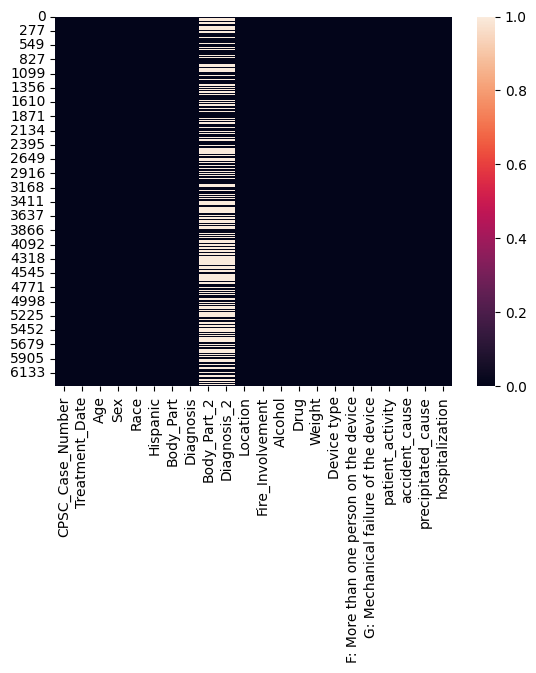

In [13]:
# heatmap to show which columns has NAs
sns.heatmap(df.isnull())
plt.show()

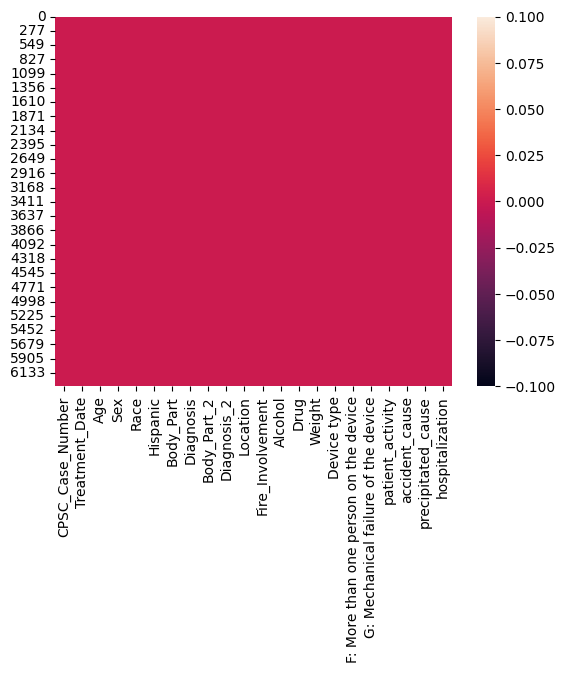

In [14]:
# change NAs to 0 for the two columns
df.update(df[['Body_Part_2','Diagnosis_2']].fillna(0))

#
sns.heatmap(df.isnull())
plt.show()


In [15]:
#percentage of data missing per column
df.isnull().sum()/df.shape[0]

CPSC_Case_Number                         0.0
Treatment_Date                           0.0
Age                                      0.0
Sex                                      0.0
Race                                     0.0
Hispanic                                 0.0
Body_Part                                0.0
Diagnosis                                0.0
Body_Part_2                              0.0
Diagnosis_2                              0.0
Location                                 0.0
Fire_Involvement                         0.0
Alcohol                                  0.0
Drug                                     0.0
Weight                                   0.0
Device type                              0.0
F: More than one person on the device    0.0
G: Mechanical failure of the device      0.0
patient_activity                         0.0
accident_cause                           0.0
precipitated_cause                       0.0
hospitalization                          0.0
dtype: flo

# Exploratory Data Analysis

In [16]:
df.dtypes

CPSC_Case_Number                           int64
Treatment_Date                            object
Age                                      float64
Sex                                       object
Race                                       int64
Hispanic                                   int64
Body_Part                                  int64
Diagnosis                                  int64
Body_Part_2                              float64
Diagnosis_2                              float64
Location                                   int64
Fire_Involvement                           int64
Alcohol                                    int64
Drug                                       int64
Weight                                   float64
Device type                               object
F: More than one person on the device      int64
G: Mechanical failure of the device        int64
patient_activity                           int64
accident_cause                             int64
precipitated_cause  

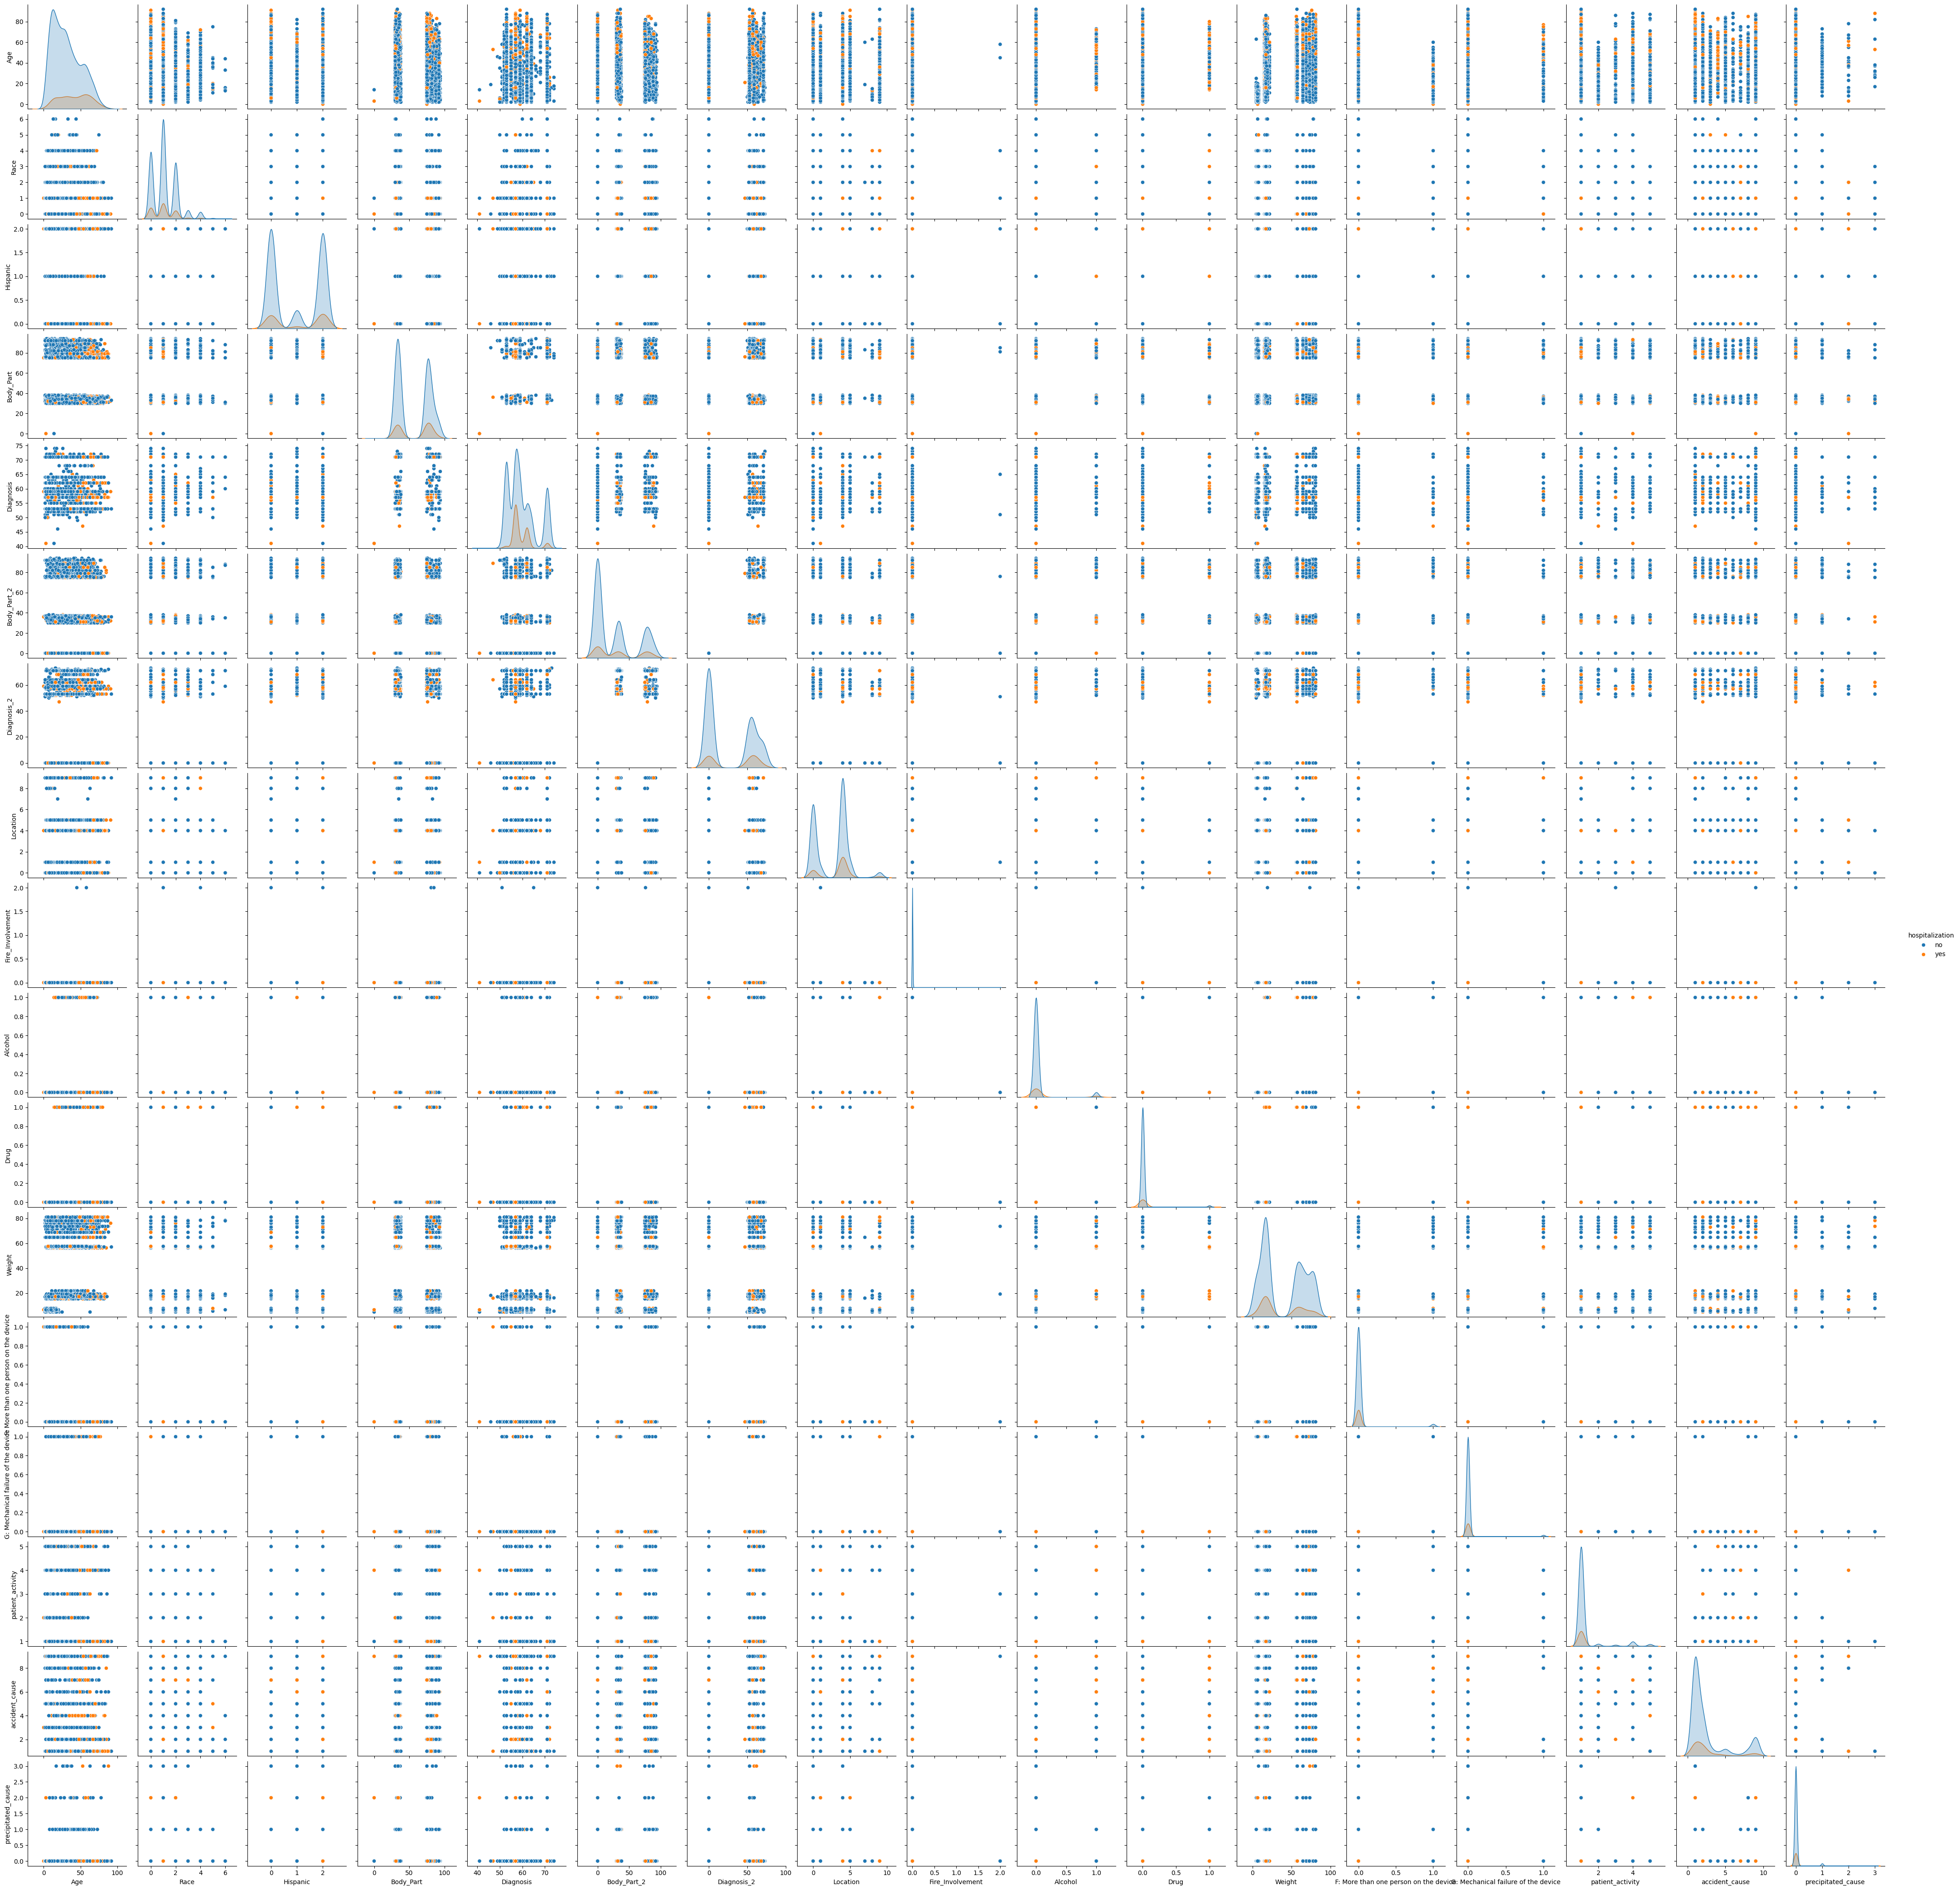

In [17]:
sns.pairplot(df.loc[:, ~df.columns.isin(['CPSC_Case_Number', 'Treatment_Date'])],hue='hospitalization')
plt.show()

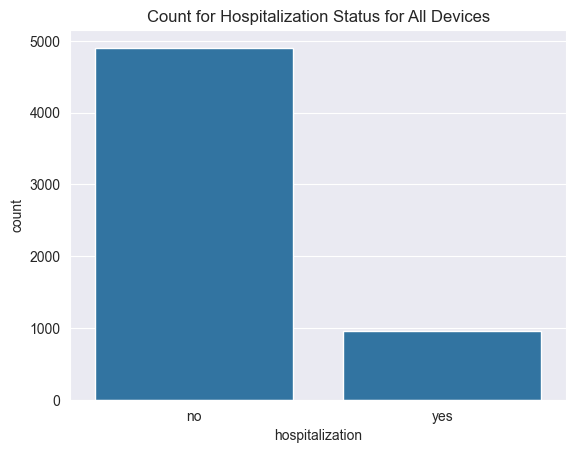

In [18]:
sns.set_style(style='darkgrid')
sns.countplot(x='hospitalization',data=df).set(title = 'Count for Hospitalization Status for All Devices')
plt.show()

In [19]:
cross_tab = pd.crosstab(index=df['Device type'],
                        columns=df['hospitalization'])


cross_tab_prop = pd.crosstab(index=df['Device type'],
                             columns=df['hospitalization'],
                             normalize="index")

In [20]:
print(pd.concat([cross_tab, cross_tab_prop],
                 keys=['      Counts', '      Proportion'],
                 axis=1))

                Counts      Proportion          
hospitalization     no  yes         no       yes
Device type                                     
BE                 795  136   0.853921  0.146079
BU                2576  412   0.862115  0.137885
MP                1533  410   0.788986  0.211014


([<matplotlib.axis.XTick at 0x160aea780>,
 [Text(0, 0, 'Electric Bike'),
  Text(1, 0, 'Man Powered Bike'),
  Text(2, 0, 'Moped')])

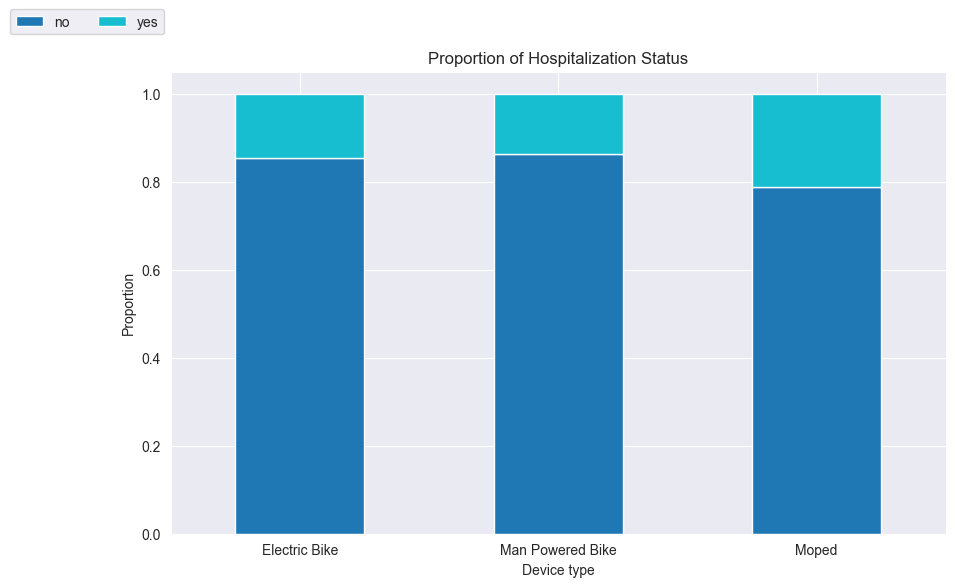

In [21]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(bbox_to_anchor=(0, 1.15), ncol=2)
plt.xlabel("Device type")
plt.ylabel("Proportion")
plt.title("Proportion of Hospitalization Status")
plt.xticks(np.arange(3), ('Electric Bike', 'Man Powered Bike', 'Moped'), rotation=0)




In [22]:
# filter for each devices and save them as a variable each
bu = df[(df['Device type'] == 'BU')]
be = df[(df['Device type'] == 'BE')]
mp = df[(df['Device type'] == 'MP')]

In [23]:
be_diag = pd.crosstab(index=be['Diagnosis'],
                        columns=be['hospitalization'])
bu_diag = pd.crosstab(index=bu['Diagnosis'],
                        columns=bu['hospitalization'])
mp_diag = pd.crosstab(index=mp['Diagnosis'],
                        columns=mp['hospitalization'])

Text(0.02, 0.5, 'Count')

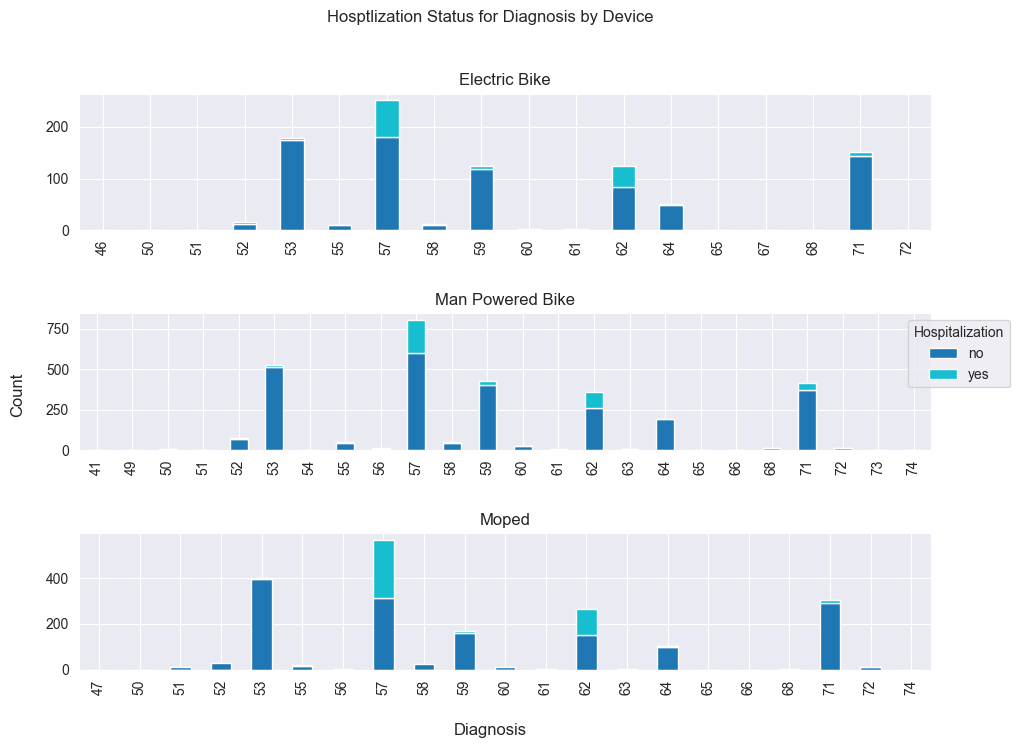

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.tight_layout(pad=2.0)

be_diag.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax1,
                    legend=False)
ax1.set(xlabel=None)
ax1.set_title("Electric Bike")

bu_diag.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax2)
ax2.set_title("Man Powered Bike")
ax2.set(xlabel=None)
ax2.legend(title='Hospitalization',bbox_to_anchor=(1.1, 1))

mp_diag.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax3,
                    legend=False)
ax3.set_title("Moped")
ax3.set(xlabel=None)
fig.suptitle('Hosptlization Status for Diagnosis by Device',y=1.05)
fig.supxlabel('Diagnosis')
fig.supylabel('Count')

In [25]:
print(pd.concat([be_diag, bu_diag, mp_diag],
                 keys=['Electric Bike', 'Man Powered Bike', ' Moped'],
                 axis=1))

                Electric Bike       Man Powered Bike         Moped       
hospitalization            no   yes               no    yes     no    yes
Diagnosis                                                                
46                        1.0   0.0              NaN    NaN    NaN    NaN
50                        1.0   0.0              4.0    1.0    1.0    0.0
51                        1.0   0.0              2.0    0.0   11.0    0.0
52                       12.0   3.0             66.0    7.0   28.0    0.0
53                      175.0   3.0            516.0    9.0  396.0    6.0
55                       10.0   1.0             43.0    5.0   19.0    4.0
57                      181.0  71.0            599.0  206.0  312.0  255.0
58                       11.0   2.0             42.0    6.0   26.0    0.0
59                      118.0   7.0            401.0   25.0  159.0   10.0
60                        3.0   0.0             25.0    2.0   14.0    0.0
61                        1.0   1.0   

**53**: Contusions, Abrasions \
**57**: Fracture \
**59**: Laceration \
**62**: Internal organ injury \
**64**: Strain or Sprain \
**71**: Other/Not Stated 

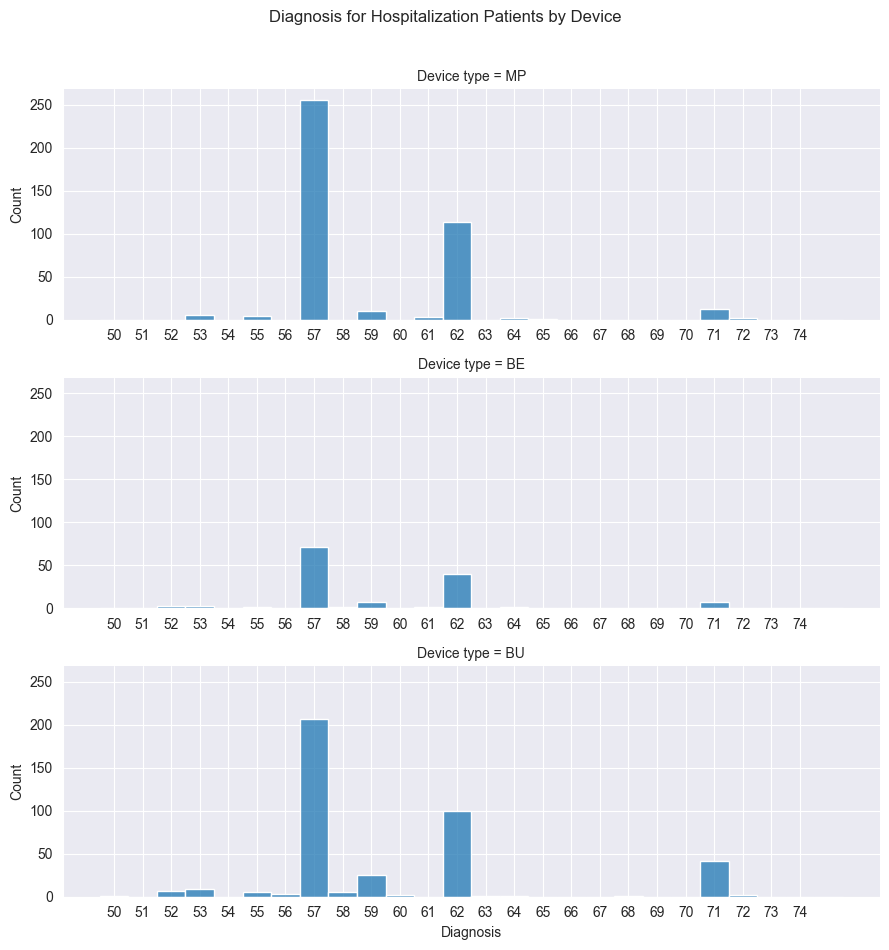

In [26]:
x = sns.FacetGrid(df[(df['hospitalization'] == 'yes')], row="Device type", aspect=3, sharex=False)
x.map(sns.histplot, "Diagnosis", binwidth = 1,  binrange=(50, 75), discrete=True)
x.fig.suptitle('Diagnosis for Hospitalization Patients by Device',y=1.05)
x.set(xticks=np.arange(50,75,1))
x.set_xticklabels(np.arange(50,75,1), rotation=0)

In [27]:
be_race = pd.crosstab(index=be['Race'],
                        columns=be['hospitalization'])
bu_race = pd.crosstab(index=bu['Race'],
                        columns=bu['hospitalization'])
mp_race = pd.crosstab(index=mp['Race'],
                        columns=mp['hospitalization'])

[Text(0, 0, 'Not Stated'),
 Text(1, 0, 'White'),
 Text(2, 0, 'Black'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'Asian'),
 Text(5, 0, 'American Indian \n Alaska Native'),
 Text(6, 0, 'Native Hawaiian \n Pacific Islander')]

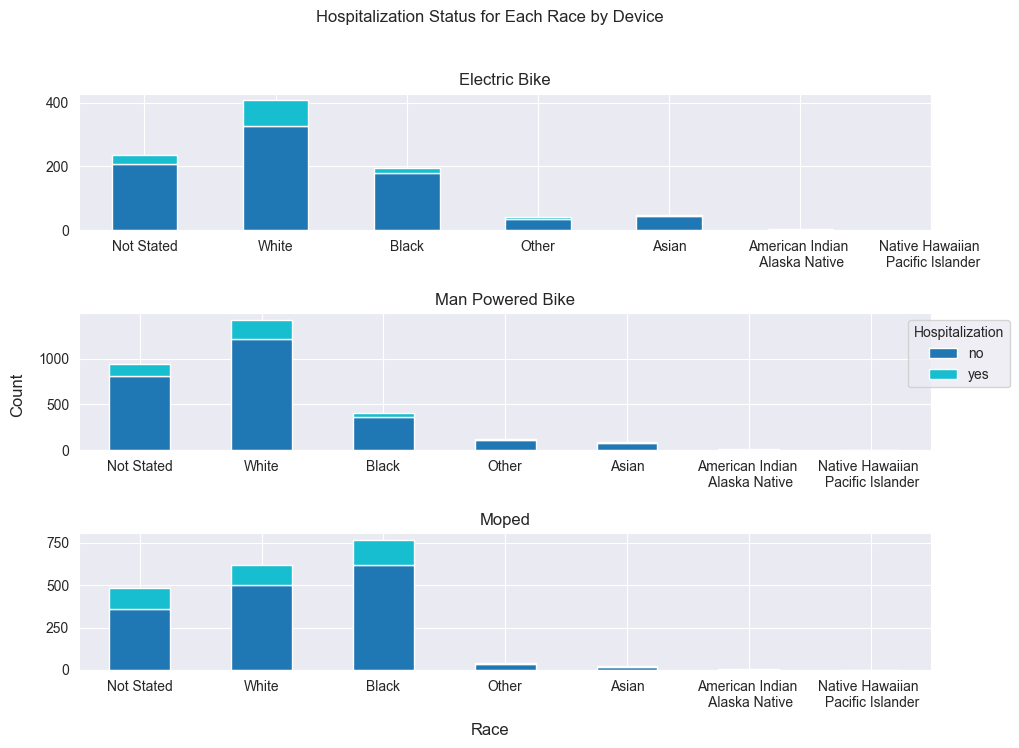

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=False)
fig.tight_layout(pad=2.0)

be_race.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax1,
                    legend=False)
ax1.set(xlabel=None)
ax1.set_title("Electric Bike")
ax1.set(xticks=np.arange(0,7,1))
ax1.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

bu_race.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax2)
ax2.set_title("Man Powered Bike")
ax2.set(xlabel=None)
ax2.legend(title='Hospitalization',bbox_to_anchor=(1.1, 1))
ax2.set(xticks=np.arange(0,7,1))
ax2.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

mp_race.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax3,
                    legend=False)
ax3.set_title("Moped")
ax3.set(xlabel=None)
fig.supxlabel('Race')
fig.supylabel('Count')
fig.suptitle('Hospitalization Status for Each Race by Device',y=1.05)
ax3.set(xticks=np.arange(0,7,1))
ax3.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

In [29]:
be_race_prop = pd.crosstab(index=be['Race'],
                        columns=be['hospitalization'],
                        normalize = 'index').round(2)
bu_race_prop = pd.crosstab(index=bu['Race'],
                        columns=bu['hospitalization'],
                        normalize = 'index').round(2)
mp_race_prop = pd.crosstab(index=mp['Race'],
                        columns=mp['hospitalization'],
                        normalize = 'index').round(2)

[Text(0, 0, 'Not Stated'),
 Text(1, 0, 'White'),
 Text(2, 0, 'Black'),
 Text(3, 0, 'Other'),
 Text(4, 0, 'Asian'),
 Text(5, 0, 'American Indian \n Alaska Native'),
 Text(6, 0, 'Native Hawaiian \n Pacific Islander')]

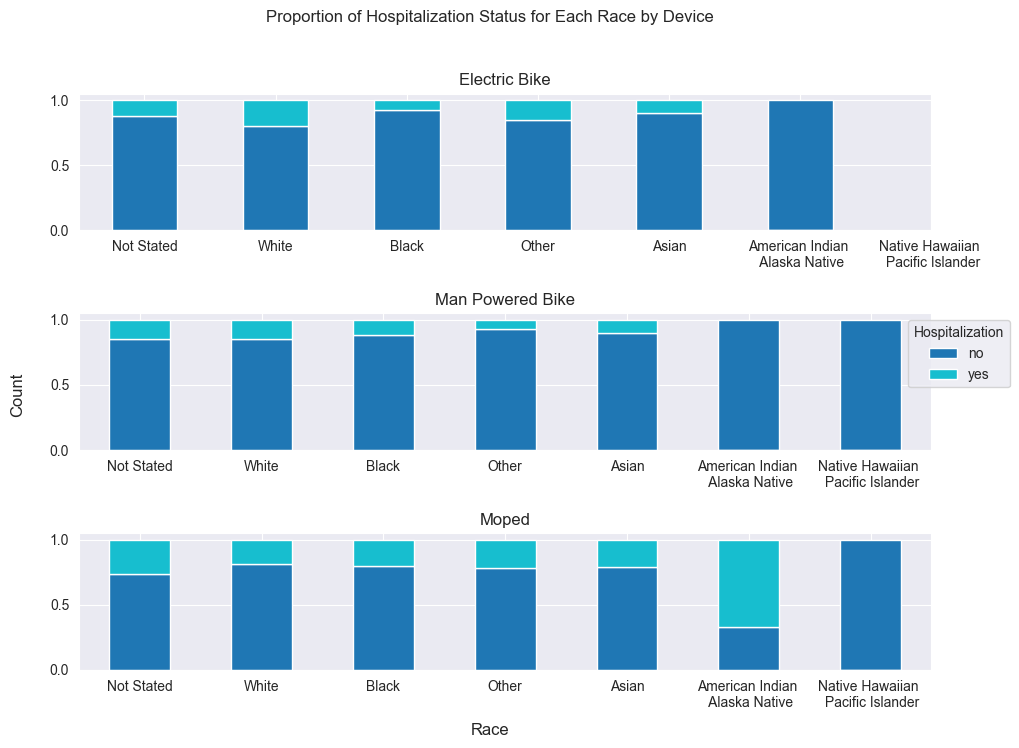

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=False)
fig.tight_layout(pad=2.0)

be_race_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax1,
                    legend=False)
ax1.set(xlabel=None)
ax1.set_title("Electric Bike")
ax1.set(xticks=np.arange(0,7,1))
ax1.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

bu_race_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax2)
ax2.set_title("Man Powered Bike")
ax2.set(xlabel=None)
ax2.legend(title='Hospitalization',bbox_to_anchor=(1.1, 1))
ax2.set(xticks=np.arange(0,7,1))
ax2.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

mp_race_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 7),
                    ax = ax3,
                    legend=False)
ax3.set_title("Moped")
ax3.set(xlabel=None)
fig.supxlabel('Race')
fig.supylabel('Count')
fig.suptitle('Proportion of Hospitalization Status for Each Race by Device',y=1.05)
ax3.set(xticks=np.arange(0,7,1))
ax3.set_xticklabels(['Not Stated', 'White', 'Black', 'Other', 'Asian', 'American Indian \n Alaska Native', 'Native Hawaiian \n Pacific Islander'], rotation=0, fontsize=10)

In [31]:
print(pd.concat([be_race_prop, bu_race_prop, mp_race_prop],
                 keys=['E-Bike', 'Man Bike', ' Moped'],
                 axis=1))

                E-Bike       Man Bike        Moped      
hospitalization     no   yes       no   yes     no   yes
Race                                                    
0                 0.88  0.12     0.85  0.15   0.74  0.26
1                 0.80  0.20     0.85  0.15   0.81  0.19
2                 0.92  0.08     0.88  0.12   0.80  0.20
3                 0.85  0.15     0.93  0.07   0.78  0.22
4                 0.90  0.10     0.90  0.10   0.79  0.21
5                 1.00  0.00     1.00  0.00   0.33  0.67
6                  NaN   NaN     1.00  0.00   1.00  0.00


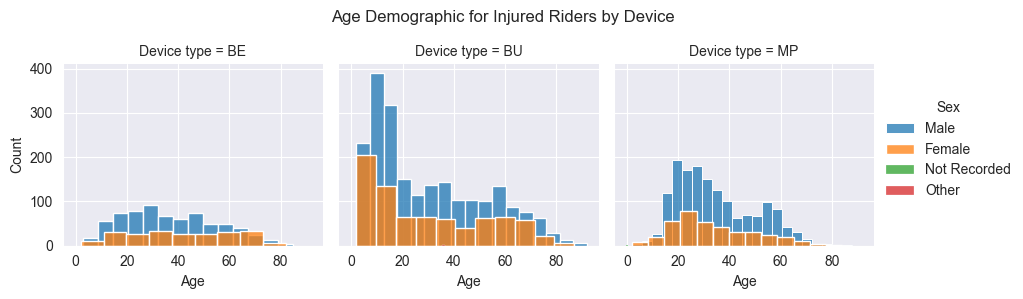

In [32]:
g = sns.FacetGrid(df, col="Device type", hue = 'Sex', col_order=['BE', 'BU', 'MP'])
g.map(sns.histplot, "Age")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Age Demographic for Injured Riders by Device')
g.add_legend()


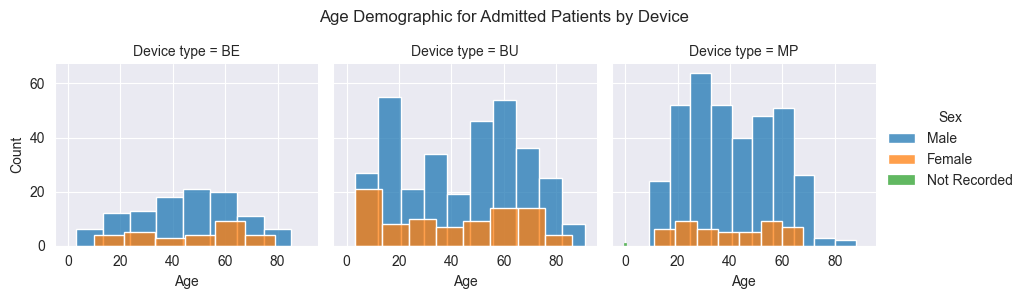

In [33]:
x = sns.FacetGrid(df[(df['hospitalization'] == 'yes')], col="Device type", hue= 'Sex', col_order=['BE', 'BU', 'MP'])
x.map(sns.histplot, "Age")
x.fig.subplots_adjust(top=0.8)
x.fig.suptitle('Age Demographic for Admitted Patients by Device')
x.add_legend()

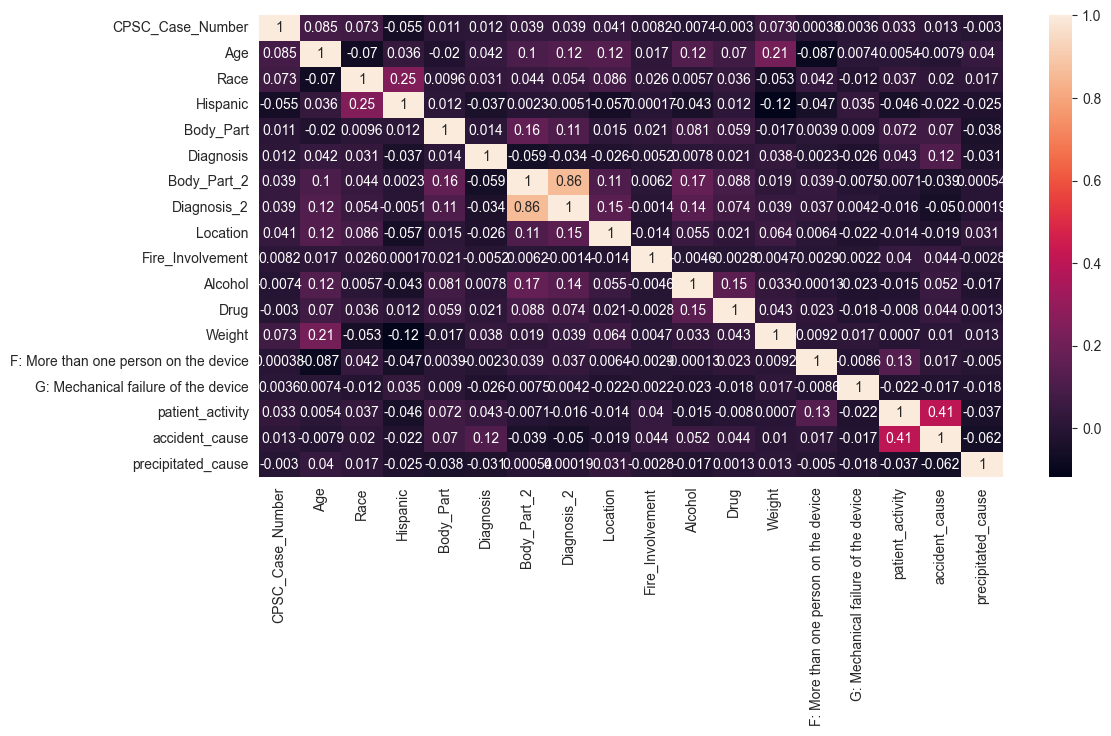

In [34]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

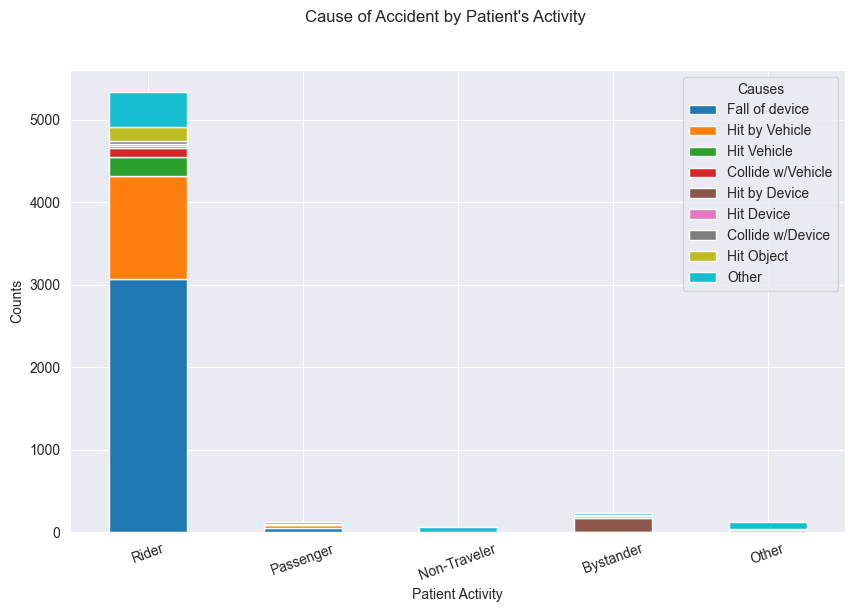

In [35]:
patient_act = pd.crosstab(index=df['patient_activity'],
                        columns=df['accident_cause'])

patient_act.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
plt.suptitle("Cause of Accident by Patient's Activity")
legend_labels = ['Fall of device', 'Hit by Vehicle', 'Hit Vehicle', 'Collide w/Vehicle', 'Hit by Device', 'Hit Device', 'Collide w/Device', 'Hit Object', 'Other']
plt.xticks(np.arange(5), ('Rider', 'Passenger', 'Non-Traveler', 'Bystander', 'Other'), rotation=20)
plt.xlabel('Patient Activity')
plt.ylabel('Counts')
plt.legend(labels = legend_labels, title = 'Causes')
plt.show()

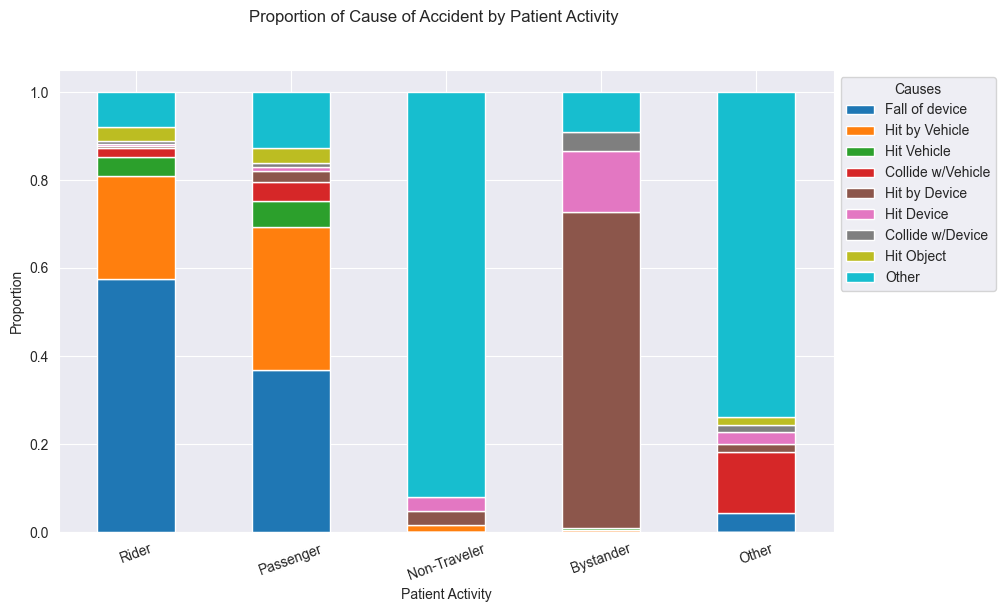

In [36]:
patient_act = pd.crosstab(index=df['patient_activity'],
                        columns=df['accident_cause'],
                        normalize="index")

patient_act.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.xticks(np.arange(5), ('Rider', 'Passenger', 'Non-Traveler', 'Bystander', 'Other'), rotation=20)
plt.xlabel('Patient Activity')
plt.ylabel('Proportion')
legend_labels = ['Fall of device', 'Hit by Vehicle', 'Hit Vehicle', 'Collide w/Vehicle', 'Hit by Device', 'Hit Device', 'Collide w/Device', 'Hit Object', 'Other']
plt.legend(labels = legend_labels, title = 'Causes', bbox_to_anchor=(1, 1))
plt.suptitle('Proportion of Cause of Accident by Patient Activity')
plt.show()

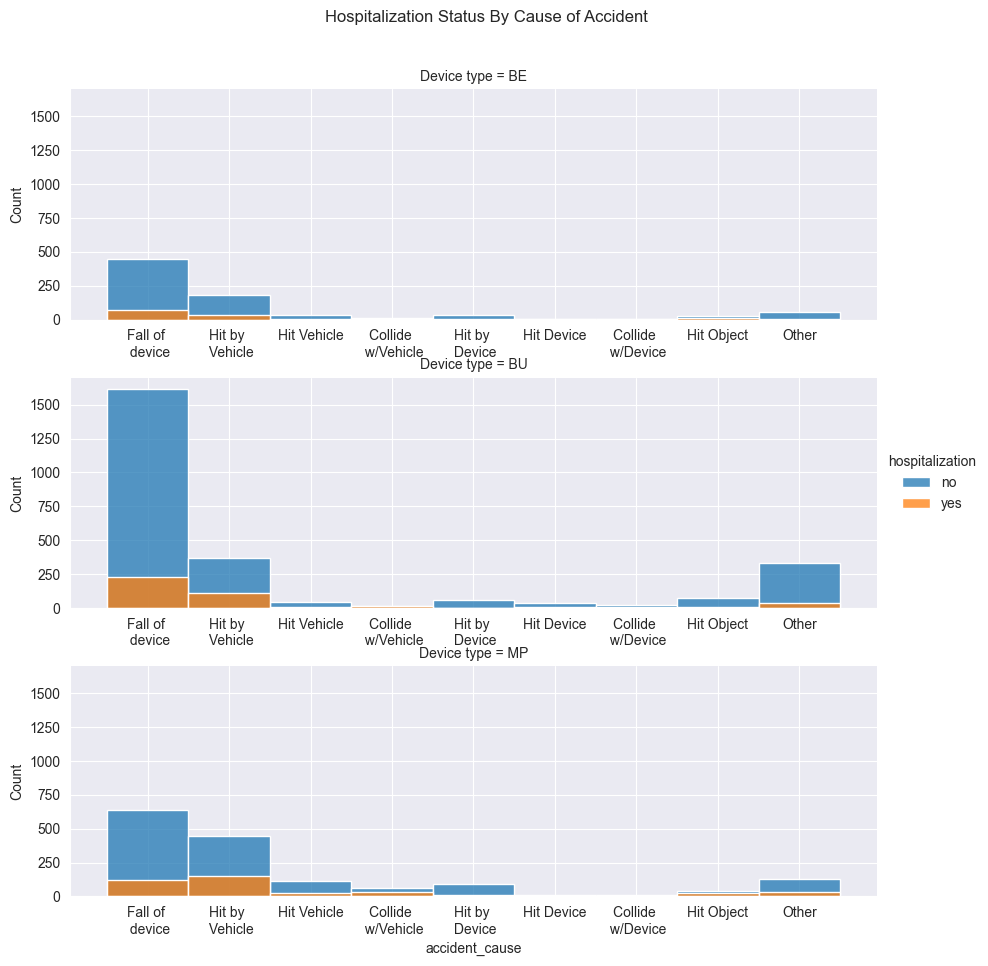

In [37]:
y = sns.FacetGrid(df, row="Device type", hue = 'hospitalization', row_order=['BE', 'BU', 'MP'], aspect=3, sharex=False)
y.map(sns.histplot, "accident_cause", binwidth = 1, discrete=True)
y.fig.suptitle('Hospitalization Status By Cause of Accident', y=1.05)
y.set(xticks=np.arange(1,10,1))
y.set_xticklabels(['Fall of \n device', 'Hit by \n Vehicle', 'Hit Vehicle', 'Collide \n w/Vehicle', 'Hit by \n Device', 'Hit Device', 'Collide \n w/Device', 'Hit Object', 'Other'], rotation=0, fontsize=10)
y.add_legend()

